# Importing Librarires

In [4]:
import pandas as pd
import os
import shutil

## Arragnging all the images in 7 sub folders under a Universal folder Reorganized.

In [6]:
data_dir=os.getcwd()+"/Dataset/all_images"
dest_dir=os.getcwd()+"/Dataset/Reorganized/"
# Read the csv file containing image names and corresponding labels
skin_df=pd.read_csv('Dataset/HAM10000_metadata.csv')
print(skin_df['dx'].value_counts())
label=skin_df['dx'].unique().tolist()
label_images=[]
for i in label:
    os.mkdir(dest_dir + str(i) + "/")
    sample = skin_df[skin_df['dx'] == i]['image_id']
    label_images.extend(sample)
    for id in label_images:
        shutil.copyfile((data_dir + "/"+ id +".jpg"), (dest_dir + i + "/"+id+".jpg"))
    label_images=[]    

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


## Processing the Images in each sub folder.

In [8]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import os
from matplotlib import pyplot as plt
datagen = ImageDataGenerator()
train_dir = os.getcwd() + "/Dataset/Reorganized/"
train_data_keras = datagen.flow_from_directory(directory=train_dir,
                                         class_mode='categorical',
                                         batch_size=16, 
                                         target_size=(32,32))

Found 10015 images belonging to 7 classes.


# Plotting the Images.

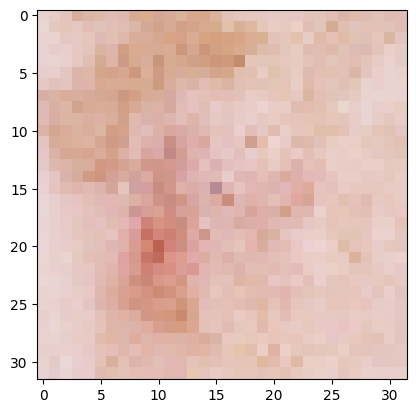

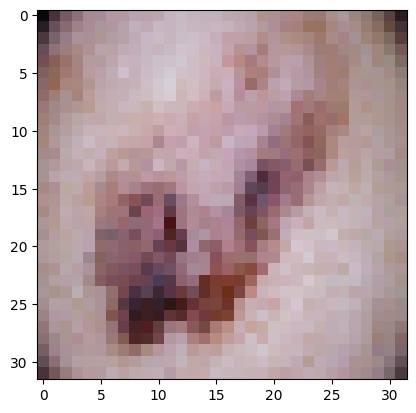

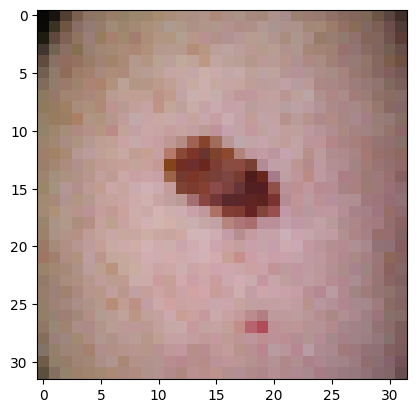

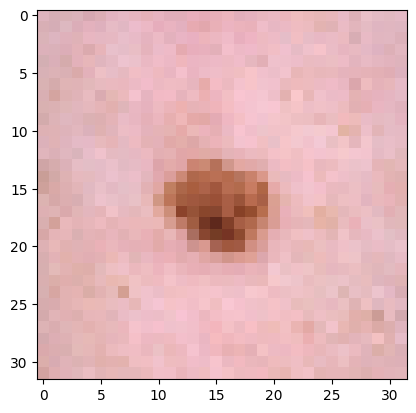

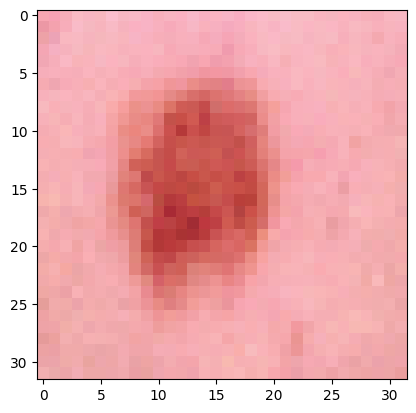

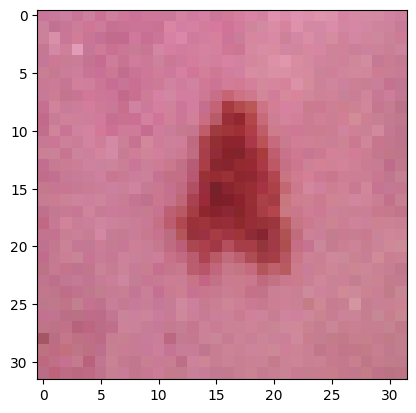

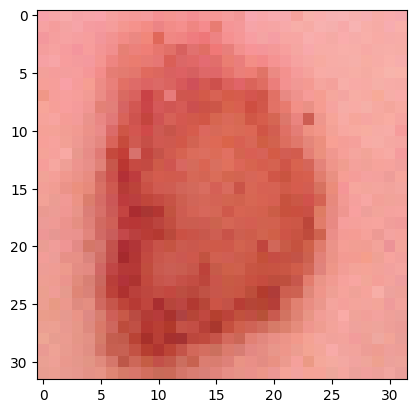

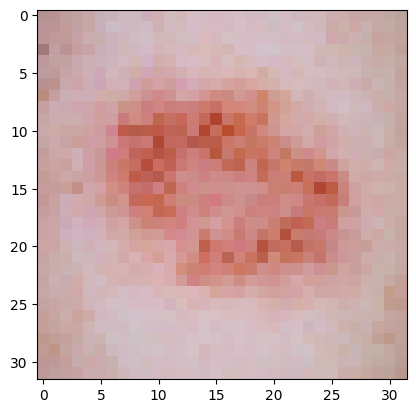

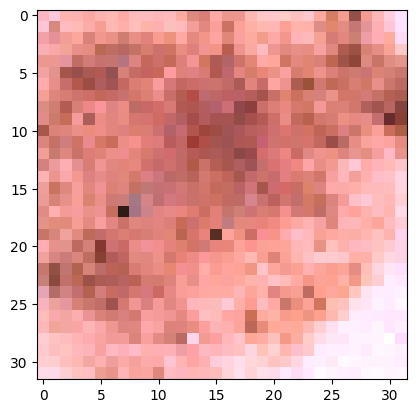

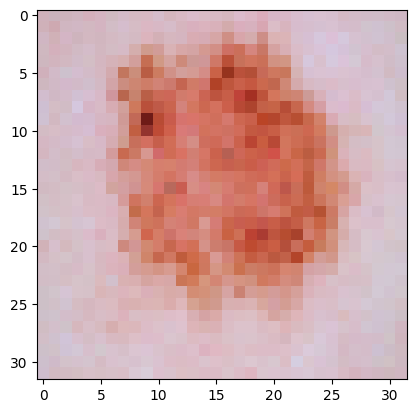

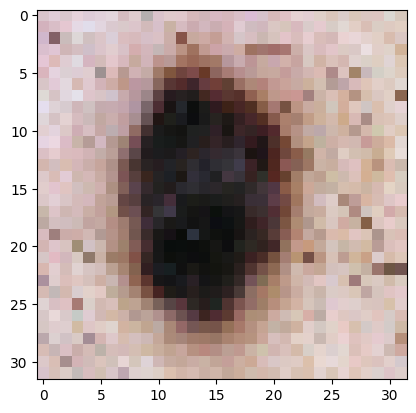

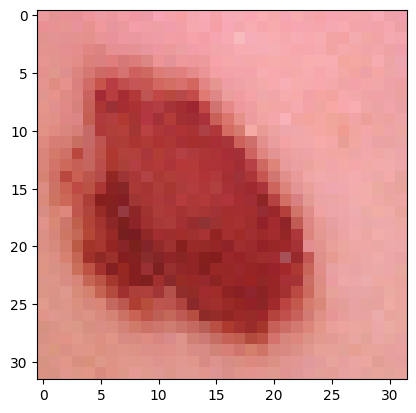

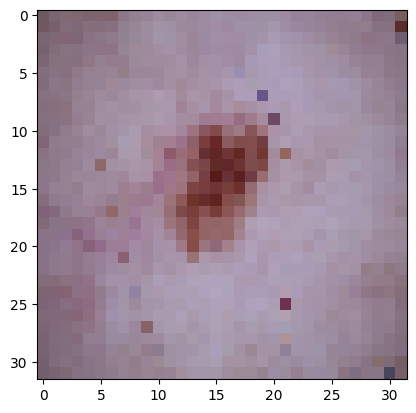

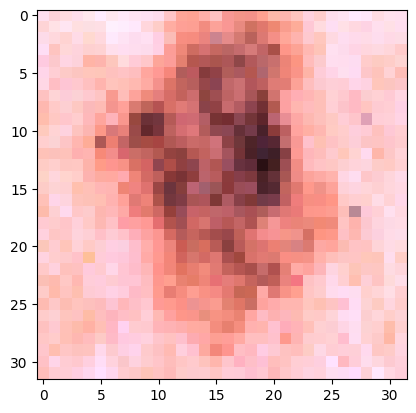

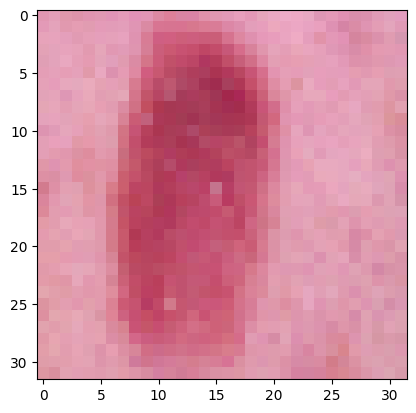

In [9]:
x, y = next(train_data_keras)
for i in range (0,15):
    image = x[i].astype(int)
    plt.imshow(image)
    plt.show()

# Importing the Libraries

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(42)
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import autokeras as ak

# Classification of Dataset

## Transforming the Labels Back to their original form.

In [11]:
skin_df = pd.read_csv('Dataset/HAM10000_metadata.csv')
SIZE=32
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extr

## Data distribution visualization

C:\Users\HP\AppData\Local\Temp\ipykernel_17744\2314019894.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


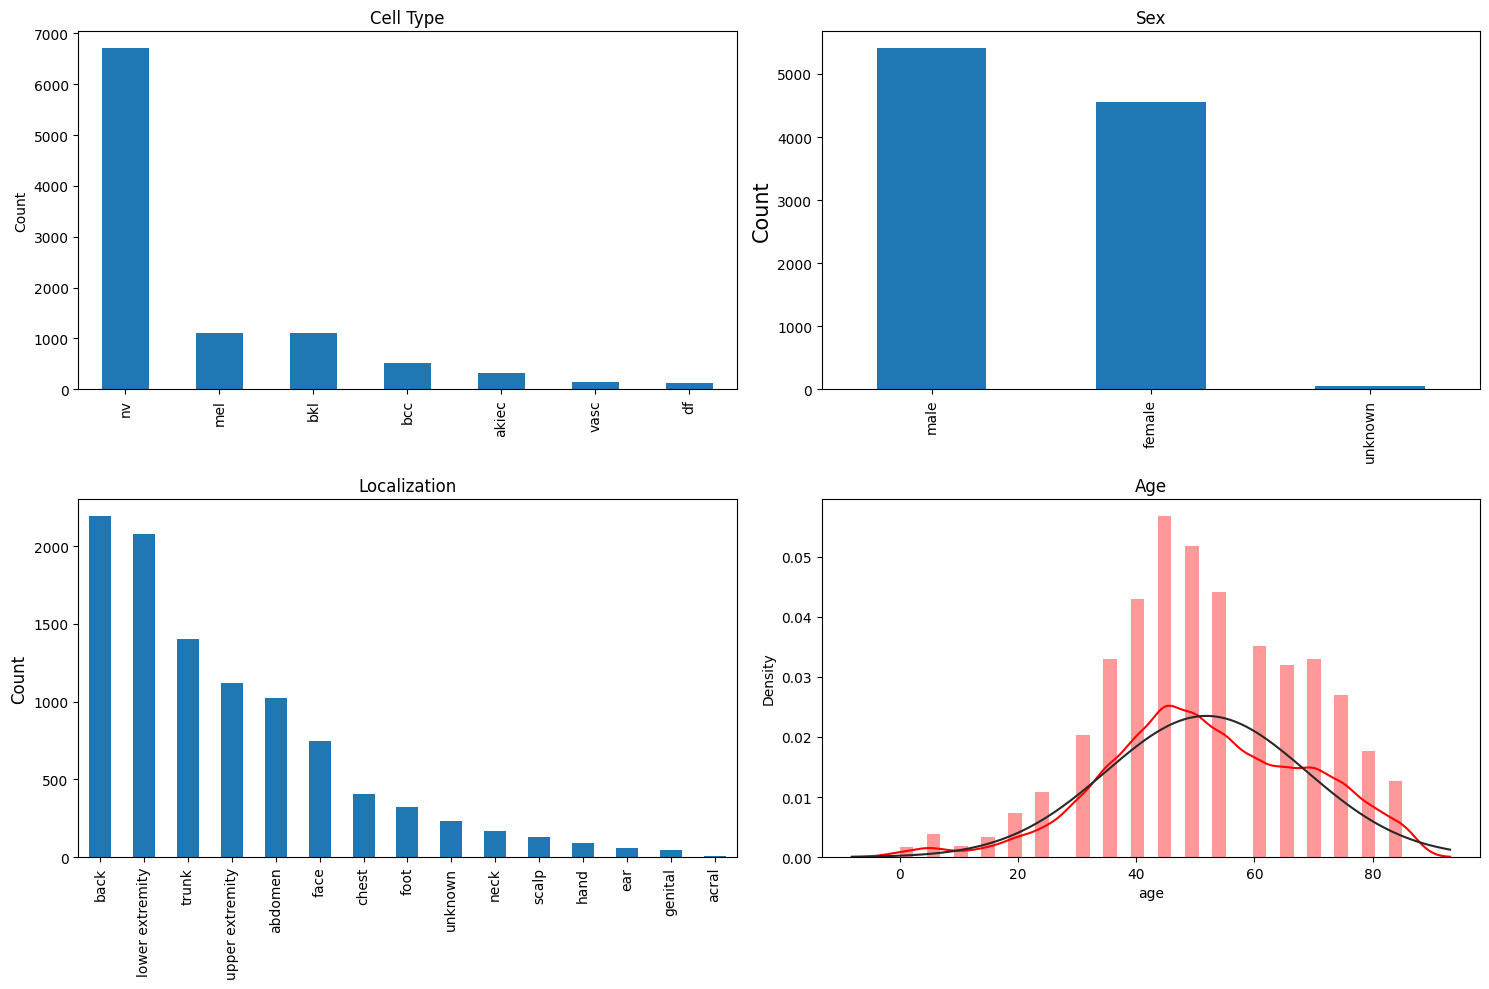

In [12]:
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

## Balancing our Dataset

In [13]:
from sklearn.utils import resample
print(skin_df['label'].value_counts())

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500 #We can choose any value but we are balancing our dataset by making each of the images of our class equal to 500.
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])
print(skin_df_balanced['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


## Balancing the Image Path

In [14]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('Dataset/', '*', '*.jpg'))}
#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [15]:
print(skin_df_balanced['path'])

9789    Dataset\HAM10000_images_part_1\ISIC_0026645.jpg
9957    Dataset\HAM10000_images_part_1\ISIC_0025780.jpg
9793    Dataset\HAM10000_images_part_1\ISIC_0024450.jpg
9758    Dataset\HAM10000_images_part_1\ISIC_0027896.jpg
9875    Dataset\HAM10000_images_part_1\ISIC_0029268.jpg
                             ...                       
2375    Dataset\HAM10000_images_part_2\ISIC_0033123.jpg
2436    Dataset\HAM10000_images_part_1\ISIC_0027790.jpg
2453    Dataset\HAM10000_images_part_1\ISIC_0024706.jpg
2377    Dataset\HAM10000_images_part_2\ISIC_0033762.jpg
2363    Dataset\HAM10000_images_part_2\ISIC_0033031.jpg
Name: path, Length: 3500, dtype: object


## Plotting the Balanced Dataset

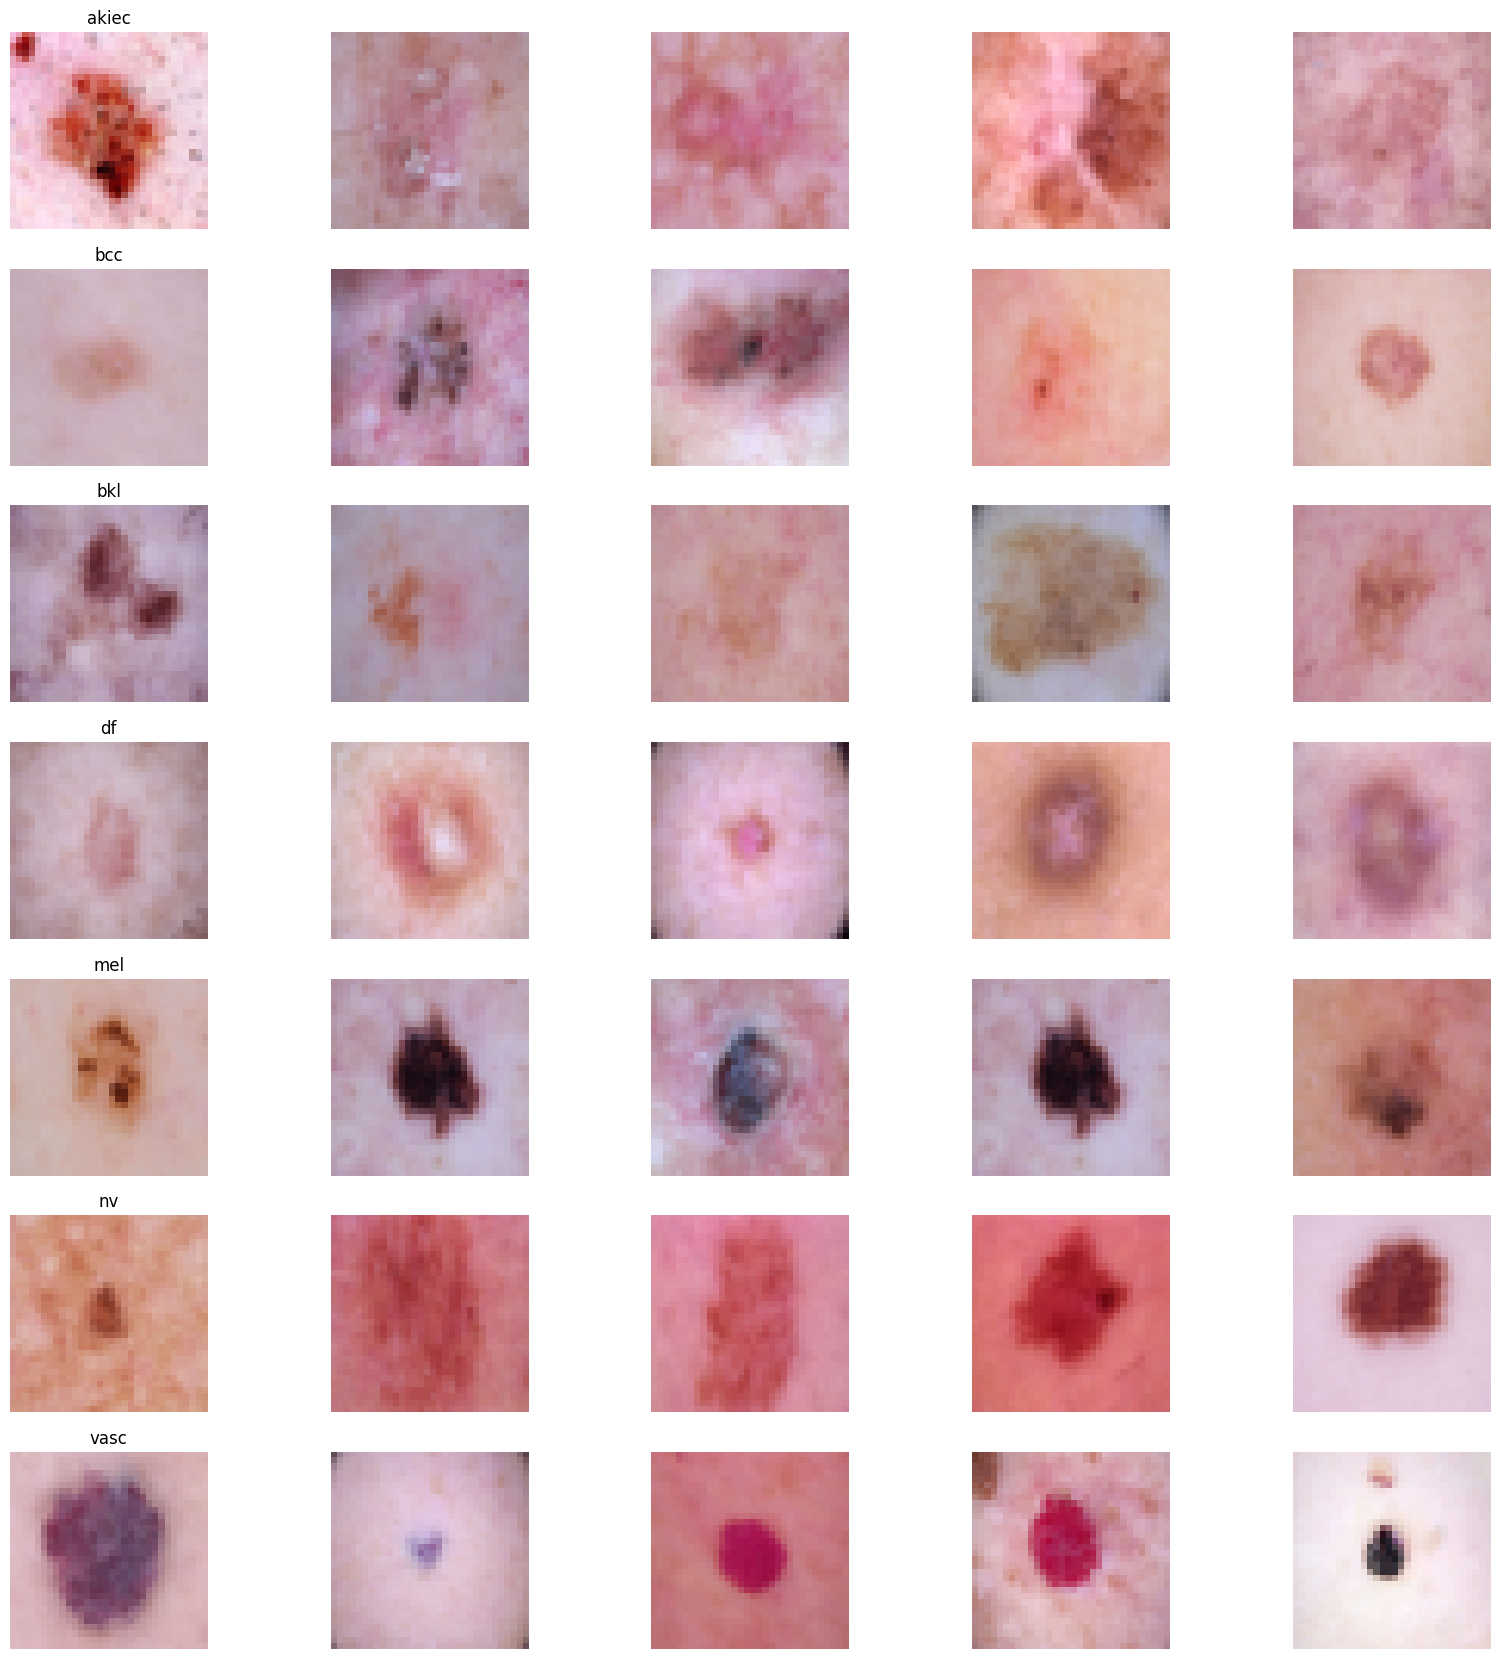

In [16]:
n_samples = 5  

# Plot
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

## Converting the dataset to X and Y trains

In [17]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255. # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label'] #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem

## Splitting the Dataset.

In [18]:
#Split to training and testing. Get a very small dataset for training as we will be 
# fitting it to many potential models. 
x_train_auto, x_test_auto, y_train_auto, y_test_auto = train_test_split(X, Y_cat, test_size=0.95, random_state=42)